In [1]:
import pyTigerGraph as tg

conn = tg.TigerGraphConnection("http://3.144.132.94", graphname="KDD_2022_NFT")

In [2]:
featurizer = conn.gds.featurizer()

In [3]:
featurizer.listAlgorithms("Centrality")

Available algorithms for category Centrality in the GDS (https://github.com/tigergraph/gsql-graph-algorithms):
pagerank: 
 global: 
  weighted: 
   Algorithm Name: tg_pagerank_wt
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/pagerank/global/weighted/tg_pagerank_wt.gsql. 
  unweighted: 
   Algorithm Name: tg_pagerank
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/pagerank/global/unweighted/tg_pagerank.gsql. 
article_rank: 
 Algorithm Name: tg_article_rank
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/article_rank/tg_article_rank.gsql. 
Betweenness: 
 Algorithm Name: tg_betweenness_cent
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Centrality/betweenness/tg_betweenness_cent.gsql. 
closeness: 
 approximate: 
  Algorithm Name: tg_closeness_cent_approx
  Algorithm Link: http

In [4]:
featurizer.installAlgorithm("tg_pagerank")

Installing and optimizing the queries, it might take a minute


'tg_pagerank'

In [5]:
params={"v_type": "NFT_User", "e_type": "USER_SOLD_TO", 'result_attr': 'pagerank'}

In [6]:
featurizer.runAlgorithm("tg_pagerank", params=params, feat_name="pagerank", schema_name=["NFT_User"], global_schema=False)

The job add_VERTEX_attr_AoDwNx completes in 23.545 seconds!


[{'@@top_scores_heap': [{'Vertex_ID': '0x76481caa104b5f6bccb540dae4cefaf1c398ebea',
    'score': 29.17597},
   {'Vertex_ID': 'contractwork', 'score': 11.47154},
   {'Vertex_ID': 'unbaw.wam', 'score': 10.88844},
   {'Vertex_ID': 'twmqw.wam', 'score': 9.4712},
   {'Vertex_ID': 'axvqu.wam', 'score': 8.56554},
   {'Vertex_ID': '0x0008d343091ef8bd3efa730f6aae5a26a285c7a2',
    'score': 7.60148},
   {'Vertex_ID': 'ruk12.wam', 'score': 7.52706},
   {'Vertex_ID': 'e2vai.waa', 'score': 7.4015},
   {'Vertex_ID': 'ey4b.wam', 'score': 6.6276},
   {'Vertex_ID': '2okbc.wam', 'score': 6.49066},
   {'Vertex_ID': '0x618242eb5b2e41ad715a6e1c01aa6d28dea2a911',
    'score': 6.45906},
   {'Vertex_ID': '1n.r2.wam', 'score': 6.45701},
   {'Vertex_ID': 'r2bak.wam', 'score': 6.03591},
   {'Vertex_ID': 'svwqu.wam', 'score': 5.77344},
   {'Vertex_ID': 'x5sr.wam', 'score': 5.76362},
   {'Vertex_ID': 'cedr.wam', 'score': 5.58719},
   {'Vertex_ID': 'p4.qw.wam', 'score': 5.5842},
   {'Vertex_ID': '0xb04239b53806ab31

In [7]:
%%writefile ./average_selling_price.gsql

CREATE QUERY average_selling_price(BOOL print_accum = FALSE, STRING result_attr =  "") { 
  AvgAccum @average_selling_price;
  users = {NFT_User.*};
  res = SELECT u FROM users:u -(USER_SOLD_NFT)-> Transaction:tgt
        ACCUM u.@average_selling_price += tgt.usd_price;
  
  res = SELECT s FROM res:s
    POST-ACCUM
        IF result_attr != "" THEN 
            IF s.@average_selling_price == 0 THEN
              s.setAttr(result_attr, -1)
            ELSE
              s.setAttr(result_attr, s.@average_selling_price) 
            END
        END;
  IF print_accum THEN
    PRINT res;
  END;
}

Overwriting ./average_selling_price.gsql


In [8]:
featurizer.installAlgorithm("average_selling_price", query_path="./average_selling_price.gsql")

Installing and optimizing the queries, it might take a minute


'average_selling_price'

In [9]:
params = {
    "result_attr": "avg_sell_price"
}

In [10]:
try:
    featurizer.runAlgorithm("average_selling_price", params=params, feat_name="avg_sell_price", feat_type="FLOAT", custom_query=True, schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("average_selling_price", params=params)

The job add_VERTEX_attr_MGrCNL completes in 29.319 seconds!


In [11]:
df = conn.getVertexDataFrame("NFT_User", where="avg_sell_price > 0", limit=100_000)
pr_sell = df[["pagerank", "avg_sell_price"]]

<AxesSubplot:xlabel='pagerank', ylabel='avg_sell_price'>

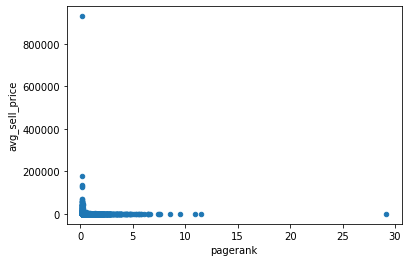

In [12]:
pr_sell.plot.scatter(x="pagerank", y="avg_sell_price")

### Remove Outliers

<AxesSubplot:xlabel='pagerank', ylabel='avg_sell_price'>

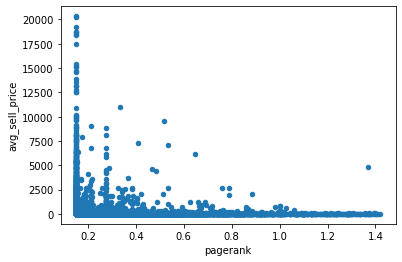

In [13]:
import numpy as np
from scipy import stats
pr_sell[(np.abs(stats.zscore(pr_sell)) < 3).all(axis=1)].plot.scatter(x="pagerank", y="avg_sell_price")

In [14]:
featurizer.listAlgorithms("Community")

Available algorithms for category Community in the GDS (https://github.com/tigergraph/gsql-graph-algorithms):
connected_components: 
 strongly_connected_components: 
  standard: 
   Algorithm Name: tg_scc
   Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/connected_components/strongly_connected_components/standard/tg_scc.gsql. 
k_core: 
 Algorithm Name: tg_kcore
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/k_core/tg_kcore.gsql. 
label_propagation: 
 Algorithm Name: tg_label_prop
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/label_propagation/tg_label_prop.gsql. 
local_clustering_coefficient: 
 Algorithm Name: tg_lcc
 Algorithm Link: https://github.com/tigergraph/gsql-graph-algorithms/blob/master/algorithms/Community/local_clustering_coefficient/tg_lcc.gsql. 
louvain: 
 Algorithm Name: tg_louvain
 Algorithm Link: https://gi

In [15]:
featurizer.installAlgorithm("tg_kcore")

Installing and optimizing the queries, it might take a minute


'tg_kcore'

In [16]:
params = {
    "v_type": "NFT_User",
    "e_type": "USER_SOLD_TO",
    "print_accum": False,
    "result_attr": "k_core"
}
try:
    featurizer.runAlgorithm("tg_kcore", params = params, feat_name="k_core")
except ConnectionError:
    featurizer.runAlgorithm("tg_kcore", params = params)

The job add_VERTEX_attr_uxNIAJ completes in 36.655 seconds!


In [17]:
df = conn.getVertexDataFrame("NFT_User", where="avg_sell_price > 0", limit=100_000)
df.head()

,v_id,nft_user_id,username,embedding,features,pagerank,avg_sell_price,k_core
0,0x902fce0d5da95620344363d5d5df60591fb6ba17,0x902fce0d5da95620344363d5d5df60591fb6ba17,Farmer_Joey,[],[],0.15,1644.13306,1
1,0xd375fd42d562a748c2d0e2421b06afbfff269e93,0xd375fd42d562a748c2d0e2421b06afbfff269e93,Rariverse,[],[],0.15,89.82188,1
2,ugnqy.wam,ugnqy.wam,,[],[],0.15,0.48289,1
3,0xa65e4f522de18eb815ea7bcd8ca18dd5fed46c14,0xa65e4f522de18eb815ea7bcd8ca18dd5fed46c14,,[],[],0.15,37.43201,1
4,y2ar.wam,y2ar.wam,,[],[],0.15,0.46104,1


In [18]:
df["k_core"].value_counts()

1      15750
2       3513
3       1197
4        591
5        358
       ...  
34         1
81         1
66         1
193        1
166        1
Name: k_core, Length: 80, dtype: int64

In [19]:
len(df["k_core"].unique())

80

In [20]:
kcore_pr_sell = df[["pagerank", "avg_sell_price", "k_core"]]

kcore_pr_sell.groupby(["k_core"]).mean()

,pagerank,avg_sell_price
k_core,,
1,0.182561,334.333047
2,0.325909,206.636971
3,0.344569,133.080814
4,0.328847,52.817302
5,0.318493,50.992773
...,...,...
193,0.150000,0.996640
215,0.564070,2.574760
334,0.150000,10.027430


In [21]:
size_of_core = df["k_core"].value_counts()

In [22]:
kcore_pr_sell["size_of_core"] = kcore_pr_sell["k_core"].apply(lambda x: size_of_core[x])

/var/folders/6m/4_05ft595_77hxj48by2vf0c0000gp/T/ipykernel_71459/485414690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kcore_pr_sell["size_of_core"] = kcore_pr_sell["k_core"].apply(lambda x: size_of_core[x])


In [23]:
kcore_pr_sell.head()

,pagerank,avg_sell_price,k_core,size_of_core
0,0.15,1644.13306,1,15750
1,0.15,89.82188,1,15750
2,0.15,0.48289,1,15750
3,0.15,37.43201,1,15750
4,0.15,0.46104,1,15750


In [24]:
kcore_pr_sell[["avg_sell_price", "size_of_core"]].corr()

,avg_sell_price,size_of_core
avg_sell_price,1.000000,0.013387
size_of_core,0.013387,1.000000


<AxesSubplot:xlabel='size_of_core', ylabel='avg_sell_price'>

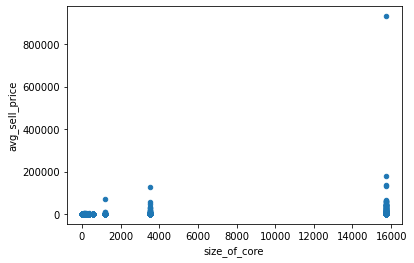

In [25]:
kcore_pr_sell.plot.scatter(x="size_of_core", y="avg_sell_price")

<AxesSubplot:xlabel='size_of_core', ylabel='avg_sell_price'>

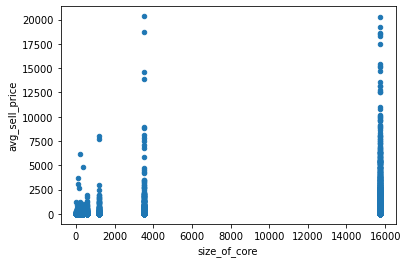

In [26]:
kcore_pr_sell[(np.abs(stats.zscore(kcore_pr_sell)) < 3).all(axis=1)].plot.scatter(x="size_of_core", y="avg_sell_price")

<AxesSubplot:xlabel='size_of_core', ylabel='pagerank'>

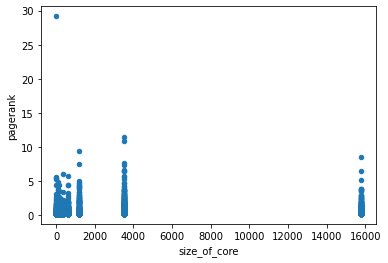

In [27]:
kcore_pr_sell.plot.scatter(x="size_of_core", y="pagerank")

<AxesSubplot:xlabel='size_of_core', ylabel='pagerank'>

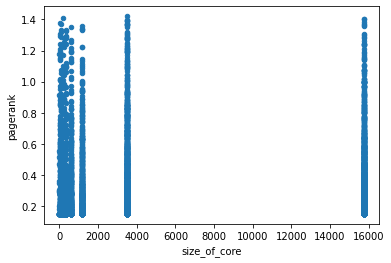

In [28]:
kcore_pr_sell[(np.abs(stats.zscore(kcore_pr_sell)) < 3).all(axis=1)].plot.scatter(x="size_of_core", y="pagerank")